In [93]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report
from sklearn import preprocessing

import lightgbm as lgb

In [34]:
#Original features

train_values = pd.read_csv('train_values.csv', index_col='building_id')
train_labels = pd.read_csv('train_labels.csv', index_col='building_id')
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')

train_value_types = train_values.columns.to_series().groupby(train_values.dtypes).groups
train_value_objects = train_value_types[list(train_value_types)[1]]
keep_features = [x for x in list(train_values.columns) if x not in train_value_objects]
object_features = [x for x in list(train_values.columns) if x in train_value_objects]
train_values_dummies = pd.get_dummies(train_values[object_features])
train_values_subset = train_values[keep_features]
#train_values_subset = pd.concat([train_values_keep, train_values_dummies], axis=1, join="inner")



test_values  = pd.read_csv('test_values.csv', index_col='building_id')
test_value_types = test_values.columns.to_series().groupby(test_values.dtypes).groups
test_value_objects = test_value_types[list(test_value_types)[1]]
keep_features = [x for x in list(test_values.columns) if x not in test_value_objects]
object_features = [x for x in list(test_values.columns) if x in test_value_objects]
test_values_dummies = pd.get_dummies(test_values[object_features])
test_values_subset = test_values[keep_features]
#test_values_subset = pd.concat([test_values_keep, test_values_dummies], axis=1, join="inner")



X = train_values_subset
Y = pd.read_csv('train_labels.csv', index_col='building_id')

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [101]:
#Remove correlated features

remove_features = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_brick','roof_type_n',             #high correlations
                   'other_floor_type_q', 'plan_configuration_d', 'ground_floor_type_f', 'land_surface_condition_t', #high correlations
                   'count_floors_pre_eq', 'count_families', 'legal_ownership_status_a', 'legal_ownership_status_r', #practical significance
                   'legal_ownership_status_v', 'legal_ownership_status_w']

train_values = pd.read_csv('train_values.csv', index_col='building_id')
train_labels = pd.read_csv('train_labels.csv', index_col='building_id')
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
train_labels_subset = pd.read_csv('train_labels.csv', index_col='building_id')


train_value_types = train_values.columns.to_series().groupby(train_values.dtypes).groups
train_value_objects = train_value_types[list(train_value_types)[1]]
keep_features = [x for x in list(train_values.columns) if x not in train_value_objects]                             #Non-object features
object_features = [x for x in list(train_values.columns) if x in train_value_objects]                               #Object features
train_values_dummies = pd.get_dummies(train_values[object_features])                                                #One hot encoding
train_values_keep = train_values[keep_features]
train_values_subset = pd.concat([train_values_keep, train_values_dummies], axis=1, join="inner")
train_values_subset = train_values_subset.drop(remove_features, axis=1)

#Dropping the outlier rows with Percentiles
upper_lim = train_values_subset['age'].quantile(.95)
lower_lim = train_values_subset['age'].quantile(.05)
filter_lim = (train_values_subset['age'] < upper_lim) & (train_values_subset['age'] > lower_lim)
train_values_subset = train_values_subset[filter_lim]
train_labels_subset = train_labels_subset[filter_lim]

test_values  = pd.read_csv('test_values.csv', index_col='building_id')
test_value_types = test_values.columns.to_series().groupby(test_values.dtypes).groups
test_value_objects = test_value_types[list(test_value_types)[1]]
keep_features = [x for x in list(test_values.columns) if x not in test_value_objects]                               #Non-object features
object_features = [x for x in list(test_values.columns) if x in test_value_objects]                                 #Object features
test_values_dummies = pd.get_dummies(test_values[object_features])                                                  #One hot encoding
test_values_keep = test_values[keep_features]
test_values_subset = pd.concat([test_values_keep, test_values_dummies], axis=1, join="inner")
test_values_subset = test_values_subset.drop(remove_features, axis=1)

X = train_values_subset
Y = train_labels_subset

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [102]:
X.columns

Index(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'age',
       'area_percentage', 'height_percentage',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_secondary_use_health_post',
       'has_secondary_use_gov_office', 'has_secondary_use_use_police',
       'has_secondary_use_other', 'land_surface_condition_n',
       'land_surface_condition_o', 'foundation_type_h', 'foundation_type_i',
       'foundation_type_r', 'foundation_type_u', 'foundation_

(array([7.1000e+01, 2.4160e+03, 9.7050e+03, 7.9672e+04, 7.4076e+04,
        4.1881e+04, 9.1050e+03, 1.2330e+03, 2.2300e+02, 6.7000e+01]),
 array([0.        , 0.46051702, 0.92103404, 1.38155106, 1.84206807,
        2.30258509, 2.76310211, 3.22361913, 3.68413615, 4.14465317,
        4.60517019]),
 <BarContainer object of 10 artists>)

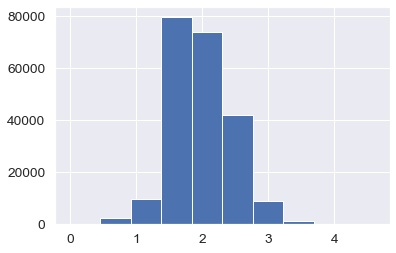

In [75]:
plt.hist(X['area_percentage'])

(array([7.19100e+03, 1.96830e+04, 3.23610e+04, 1.08637e+05, 3.03530e+04,
        1.79540e+04, 1.71500e+03, 4.30000e+02, 5.20000e+01, 7.30000e+01]),
 array([0.69314718, 0.97040605, 1.24766493, 1.5249238 , 1.80218267,
        2.07944154, 2.35670041, 2.63395929, 2.91121816, 3.18847703,
        3.4657359 ]),
 <BarContainer object of 10 artists>)

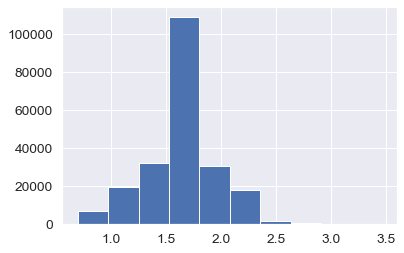

In [78]:
plt.hist(X['height_percentage'])

(array([22656., 22165., 21525., 21890., 21084., 21276., 22424., 21552.,
        22439., 21438.]),
 array([    0. ,  1256.7,  2513.4,  3770.1,  5026.8,  6283.5,  7540.2,
         8796.9, 10053.6, 11310.3, 12567. ]),
 <BarContainer object of 10 artists>)

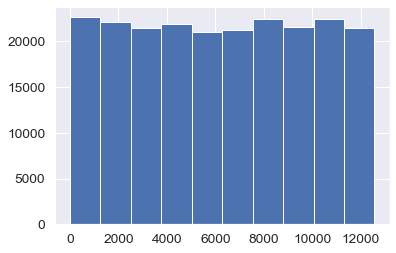

In [65]:
plt.hist(X['geo_level_3_id'])

In [20]:
#Pairplots
sns.pairplot(X.join(Y), 
             hue='damage_grade')

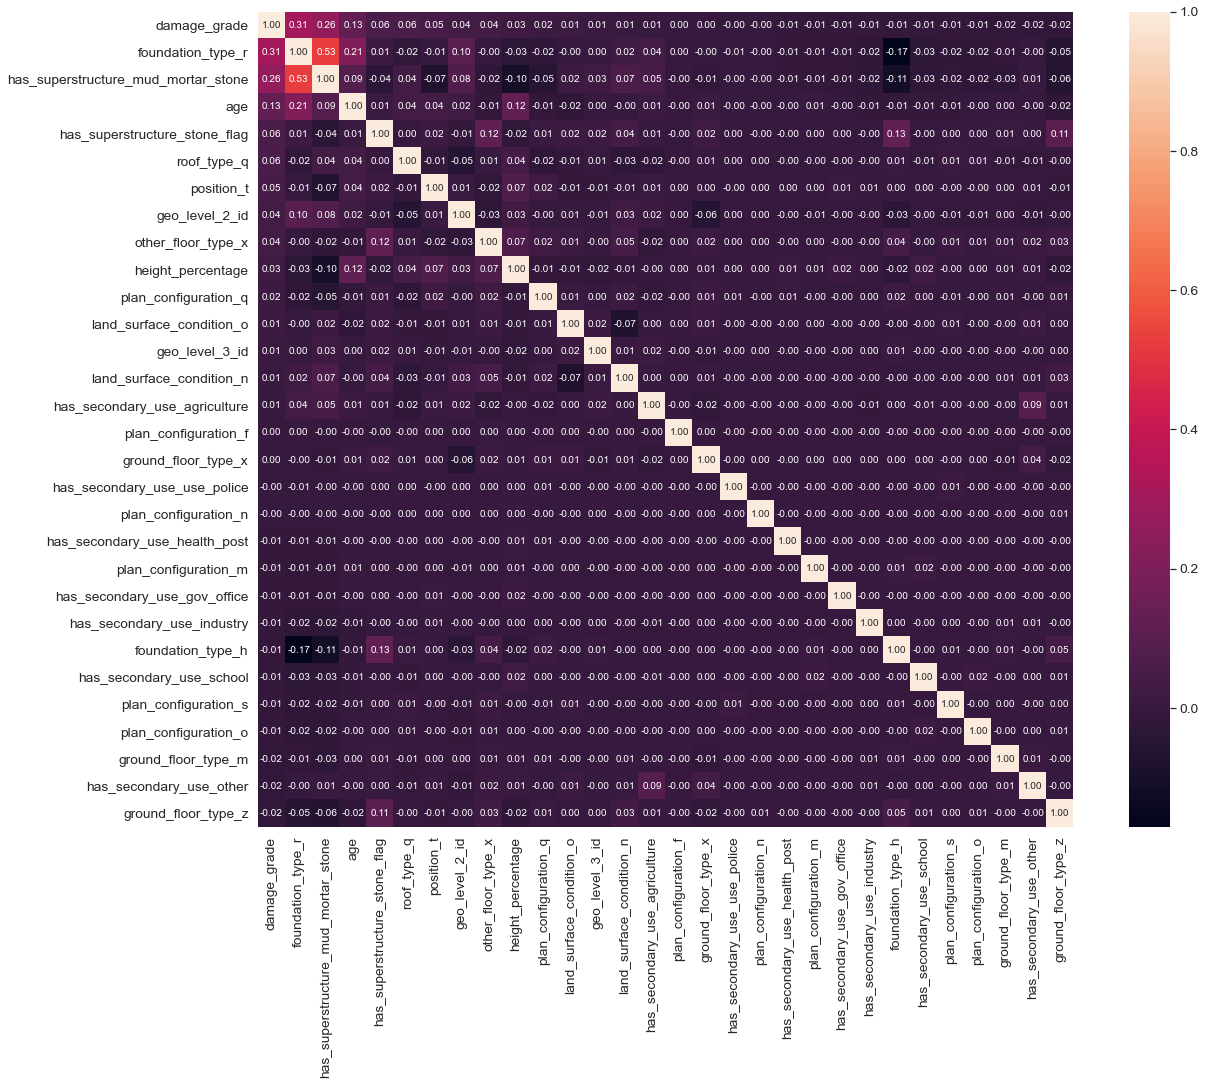

In [33]:
# Strongest positive correlations
all_data = X.join(Y)
corrmat = all_data.corr()
k = 30 #number of variables for heatmap
cols = corrmat.nlargest(k, 'damage_grade')['damage_grade'].index
cm = np.corrcoef(all_data[cols].values.T)
f, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, yticklabels=cols.values, 
                 xticklabels=cols.values)
plt.show()

In [37]:
#Default XGB Model
model = XGBClassifier()

parameters = {}

clf = GridSearchCV(model, parameters)

clf.fit(X, Y.values.ravel())

clf.best_estimator_

pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,43.98412,0.708258,0.22211,0.011515,{},0.730213,0.728244,0.733532,0.731174,0.731008,0.730834,0.001704,1


In [39]:
#Gridsearch Model
model = XGBClassifier()

parameters = {'max_depth': [6,9,12],
              'min_child_weight' : [1,5,9,12],
              'eta' : [.01, .3, 1],
              'colsample_bytree' : [1],
              'gamma':[0],
              'objective' : ['reg:linear'],
              'verbosity':[0]}

clf = GridSearchCV(model, parameters)

clf.fit(X,Y.values.ravel())

clf.best_estimator_

pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_eta,param_gamma,param_max_depth,param_min_child_weight,param_objective,param_verbosity,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,43.288626,2.842762,0.169570,0.010618,1,0.01,0,6,1,reg:linear,0,"{'colsample_bytree': 1, 'eta': 0.01, 'gamma': ...",0.682284,0.677066,0.682055,0.682673,0.682483,0.681312,0.002133,36
1,39.864515,0.992770,0.179180,0.009422,1,0.01,0,6,5,reg:linear,0,"{'colsample_bytree': 1, 'eta': 0.01, 'gamma': ...",0.682193,0.677203,0.682490,0.682513,0.682575,0.681395,0.002100,33
2,39.767065,0.481179,0.172233,0.006056,1,0.01,0,6,9,reg:linear,0,"{'colsample_bytree': 1, 'eta': 0.01, 'gamma': ...",0.682399,0.677020,0.682238,0.682742,0.682506,0.681381,0.002187,34
3,39.391970,0.370908,0.170852,0.004615,1,0.01,0,6,12,reg:linear,0,"{'colsample_bytree': 1, 'eta': 0.01, 'gamma': ...",0.682170,0.676951,0.682444,0.682605,0.682689,0.681372,0.002217,35
4,63.086716,0.547242,0.304418,0.010240,1,0.01,0,9,1,reg:linear,0,"{'colsample_bytree': 1, 'eta': 0.01, 'gamma': ...",0.699542,0.697826,0.699977,0.699725,0.699581,0.699330,0.000768,30
5,62.822151,0.365050,0.297419,0.014614,1,0.01,0,9,5,reg:linear,0,"{'colsample_bytree': 1, 'eta': 0.01, 'gamma': ...",0.699336,0.698032,0.699954,0.700137,0.699467,0.699385,0.000739,29
6,62.775578,0.167087,0.309545,0.020924,1,0.01,0,9,9,reg:linear,0,"{'colsample_bytree': 1, 'eta': 0.01, 'gamma': ...",0.699336,0.698283,0.699794,0.699222,0.698849,0.699097,0.000506,31
7,62.288276,0.324210,0.286878,0.014634,1,0.01,0,9,12,reg:linear,0,"{'colsample_bytree': 1, 'eta': 0.01, 'gamma': ...",0.699199,0.697917,0.698650,0.699863,0.699123,0.698950,0.000645,32
8,90.578265,0.058040,0.694797,0.024156,1,0.01,0,12,1,reg:linear,0,"{'colsample_bytree': 1, 'eta': 0.01, 'gamma': ...",0.717029,0.718242,0.722660,0.718402,0.719128,0.719092,0.001907,26
9,87.859202,0.317326,0.630305,0.014804,1,0.01,0,12,5,reg:linear,0,"{'colsample_bytree': 1, 'eta': 0.01, 'gamma': ...",0.717189,0.718036,0.722179,0.719867,0.719540,0.719362,0.001715,25


In [84]:
#Gridsearch Model
model = XGBClassifier()

parameters = {'max_depth': [9],
              'min_child_weight' : [9],
              'eta' : [.3],
              'colsample_bytree' : [1],
              'gamma':[0],
              'objective' : ['reg:linear'],
              'verbosity':[0],
              'scale_pos_weight':[1, 25, 50, 75, 99, 100, 1000]}

clf = GridSearchCV(model, parameters)

clf.fit(X,Y.values.ravel())

clf.best_estimator_

pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_eta,param_gamma,param_max_depth,param_min_child_weight,param_objective,...,param_verbosity,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,86.954202,5.020955,0.515545,0.139537,1,0.3,0,9,9,reg:linear,...,0,"{'colsample_bytree': 1, 'eta': 0.3, 'gamma': 0...",0.743397,0.739048,0.747608,0.743488,0.742063,0.743121,0.002759,1
1,96.757229,25.023626,0.454391,0.116642,1,0.3,0,9,9,reg:linear,...,0,"{'colsample_bytree': 1, 'eta': 0.3, 'gamma': 0...",0.743397,0.739048,0.747608,0.743488,0.742063,0.743121,0.002759,1
2,78.766380,1.843397,0.447055,0.075638,1,0.3,0,9,9,reg:linear,...,0,"{'colsample_bytree': 1, 'eta': 0.3, 'gamma': 0...",0.743397,0.739048,0.747608,0.743488,0.742063,0.743121,0.002759,1
3,87.852730,2.310531,0.519572,0.100241,1,0.3,0,9,9,reg:linear,...,0,"{'colsample_bytree': 1, 'eta': 0.3, 'gamma': 0...",0.743397,0.739048,0.747608,0.743488,0.742063,0.743121,0.002759,1
4,81.839159,4.178051,0.376910,0.048390,1,0.3,0,9,9,reg:linear,...,0,"{'colsample_bytree': 1, 'eta': 0.3, 'gamma': 0...",0.743397,0.739048,0.747608,0.743488,0.742063,0.743121,0.002759,1
5,77.453506,3.608036,0.374400,0.070587,1,0.3,0,9,9,reg:linear,...,0,"{'colsample_bytree': 1, 'eta': 0.3, 'gamma': 0...",0.743397,0.739048,0.747608,0.743488,0.742063,0.743121,0.002759,1
6,82.083747,4.820359,0.382607,0.039225,1,0.3,0,9,9,reg:linear,...,0,"{'colsample_bytree': 1, 'eta': 0.3, 'gamma': 0...",0.743397,0.739048,0.747608,0.743488,0.742063,0.743121,0.002759,1


In [85]:
#Generate prediction using best parameters
model.set_params(**clf.best_params_)
model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred))

model.fit(X, Y.values.ravel())

prediction4 = model.predict(test_values_subset)

my_submission4 = pd.DataFrame(data=prediction4,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission4.to_csv('XGBsubmission.csv')
!head XGBsubmission.csv

0.7395441745619997
building_id,damage_grade
300051,3
99355,2
890251,2
745817,2
421793,3
871976,2
691228,2
896100,3
343471,2


In [88]:
#Testing accuracy using custom parameters
model.set_params(colsample_bytree= 1,
 eta= 0.3,
 gamma= 0,
 max_depth= 9,
 min_child_weight= 5,
 objective= 'reg:linear',
 subsample= 1,
 verbosity= 0)

model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

0.7381015134070386

In [87]:
#Generate prediction using best parameters
model.set_params(colsample_bytree= 1,
 eta= 0.3,
 gamma= 0,
 max_depth= 9,
 min_child_weight= 5,
 objective= 'reg:linear',
 subsample= 1,
 verbosity= 0)
model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred))

model.fit(X, Y.values.ravel())

prediction4 = model.predict(test_values_subset)

my_submission4 = pd.DataFrame(data=prediction4,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission4.to_csv('XGBsubmission.csv')
!head XGBsubmission.csv

0.7381015134070386
building_id,damage_grade
300051,3
99355,2
890251,2
745817,2
421793,3
871976,2
691228,2
896100,3
343471,2


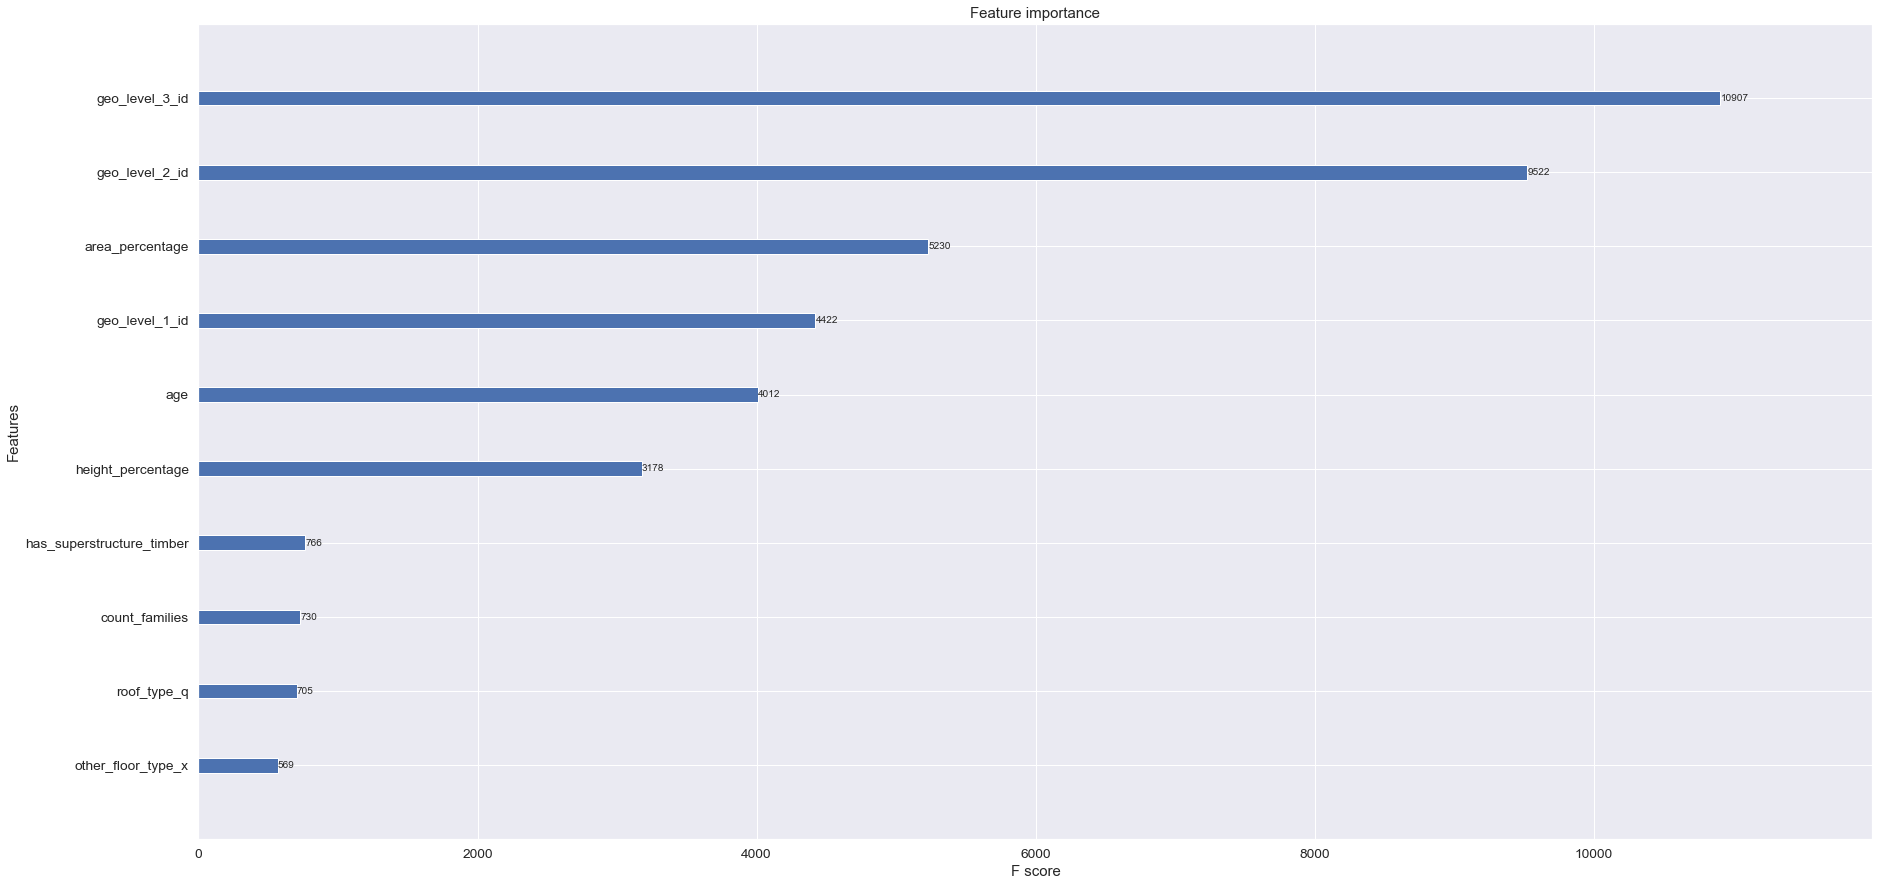

In [99]:
#Analyze feature importance from model
plt.rcParams["figure.figsize"] = (30,15)
ax.set_facecolor('xkcd:white')
ax = plot_importance(model, max_num_features=10)
plt.savefig('file.jpeg', edgecolor='black', dpi=200, facecolor='white', transparent=True)
plt.show()
